<a href="https://colab.research.google.com/github/jfb10d/Natural-Language-Processing/blob/main/notebooks/FakeNewsClassifierUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fake News Classifier Using LSTM

Dataset: https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification

In [1]:
import pandas as pd

In [12]:
df=pd.read_csv('fake_news_train.csv', on_bad_lines='skip', sep=';',index_col=0)

In [15]:
df.head()

,title,text,label
0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [16]:
df.shape

(24353, 3)

In [17]:
df.isnull().sum()

,0
title,0
text,0
label,0


In [18]:
## Get the Independent Features

X=df.drop('label',axis=1)

In [19]:
## Get the Dependent features
y=df['label']

In [22]:
X.shape, y.shape

((24353, 2), (24353,))

In [23]:
import tensorflow as tf

In [24]:
tf.__version__

'2.19.0'

In [25]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [26]:
### Vocabulary size
voc_size=5000

### Onehot Representation

In [27]:
messages=X.copy()

In [28]:
messages['title'][1]

"China says Trump call with Taiwan president won't change island's status"

In [35]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [36]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [47]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer ##stemming purpose
lemmatizer = nltk.WordNetLemmatizer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub("'", '', messages['title'][i])
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review]# if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [49]:
corpus[10]

'a north korea nuclear test over the pacific logical terrifying'

In [51]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [52]:
corpus[1]

'china say trump call with taiwan president wont change island status'

In [53]:
onehot_repr[1]

[229, 310, 2304, 4074, 995, 4340, 462, 3257, 3896, 1553, 2782]

### Embedding Representation

In [58]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[4852 2998 2047 ...    0    0    0]
 [ 229  310 2304 ...    0    0    0]
 [4391 2529 2304 ...    0    0    0]
 ...
 [2304 3407 4435 ...    0    0    0]
 [4950 4443 3196 ...    0    0    0]
 [2886 3218 2765 ...    0    0    0]]


In [60]:
## Creating model
embedding_features=40 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.build((None, sent_length))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 40)         │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        56,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,501 (1001.96 KB)

 Trainable params: 256,501 (1001.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [61]:
len(embedded_docs),y.shape

(24353, (24353,))

In [62]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [63]:
X_final.shape,y_final.shape

((24353, 20), (24353,))

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### Model Training

In [65]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8208 - loss: 0.3728 - val_accuracy: 0.9200 - val_loss: 0.2196
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9429 - loss: 0.1659 - val_accuracy: 0.9295 - val_loss: 0.1988
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9572 - loss: 0.1294 - val_accuracy: 0.9224 - val_loss: 0.2041
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9643 - loss: 0.1047 - val_accuracy: 0.9179 - val_loss: 0.2357
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9751 - loss: 0.0759 - val_accuracy: 0.9163 - val_loss: 0.2625
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9810 - loss: 0.0584 - val_accuracy: 0.9184 - val_loss: 0.2583
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9850 - loss: 0.0453 - val_accuracy: 0.9166 - val_loss: 0.3021
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9863 - loss: 0.0442 - val_accuracy: 0

### Adding Dropout and early stopping

In [70]:
from tensorflow.keras.layers import Dropout
## Creating model

model=Sequential()
model.add(Embedding(voc_size,embedding_features,input_length=sent_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01,restore_best_weights=True)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64, callbacks=[callback])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8008 - loss: 0.3937 - val_accuracy: 0.9297 - val_loss: 0.2022
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9441 - loss: 0.1657 - val_accuracy: 0.9303 - val_loss: 0.1960
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9572 - loss: 0.1281 - val_accuracy: 0.9263 - val_loss: 0.2061
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9631 - loss: 0.1068 - val_accuracy: 0.9248 - val_loss: 0.2234


### Performance Metrics And Accuracy

In [84]:
y_pred=model.predict(X_test)

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [91]:
y_pred_bin=np.where(y_pred > 0.5, 1,0) ##AUC ROC Curve

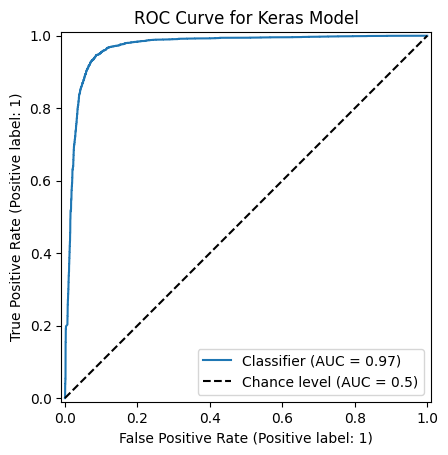

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

metrics.RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level=True)
plt.title('ROC Curve for Keras Model')
plt.show()

In [78]:
from sklearn.metrics import confusion_matrix

In [92]:
confusion_matrix(y_test,y_pred_bin)

array([[3228,  377],
       [ 188, 4244]])

In [93]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred_bin)

0.9297001368669902

In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_bin))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3605
           1       0.92      0.96      0.94      4432

    accuracy                           0.93      8037
   macro avg       0.93      0.93      0.93      8037
weighted avg       0.93      0.93      0.93      8037

